In [1]:
# default_exp transforms
# all_slow

In [2]:
# hide
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
# ! [ -e /content ] && pip install -Uqq albumentations  # upgrade albumentations

In [3]:
# hide
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/Colab Notebooks/severstal")

# Transforms

> Fastai Transforms API to Severstal dataset.

In [4]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# export
from fastai.vision.all import *
import os
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold
from steel_segmentation.utils import rle2mask, mask2rle, get_train_df
import albumentations as alb

The `fastai` data block API cannot give us a tuple (`input`,`target`) data for our Deep Learning model.
That's why we need to create custom `Transform`s to fix this problem and leverage anyway the high level framework.

In [6]:
path = Path("../data")
assert path.is_dir()

In [7]:
train_pivot = get_train_df(path, only_faulty=True, pivot=True)
print("Train pivot shape: ", train_pivot.shape)
train_pivot.head(n=3)

Train pivot shape:  (6578, 6)


ClassId,1,2,3,4,n,ClassIds
ImageId,,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...,NaN,NaN,NaN,1,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63,NaN,1,3
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 38863 28 39119 28 39375 29 39631 29 39887 29 40143 29 40399 29 40655 30 40911 30 41167 30 41423 30 41679 31 41935 31 42191 31 42447 31 42703 31 42960 31 43216 31 43472 31 43728 31 43984 31 44240 32 44496 32 44752 32 45008 32 45264 33 45520 33 45776 33 46032 33 46288 33 46544 34 46803 31 47065 25 47327 19 47588 15 47850 9 48112 3 62667 12 62923 23 63179 23 63348 3 63435 23 63604 7 63691 23 63860 11 63947 23 64116 15 64203 23 64372 19 64459 23 64628 24 64715 23 64884 28 64971 23 65139 33 65227 23 65395 37 65483 23 65651 41 65740 22 65907 45 65996 22...,NaN,NaN,NaN,1,1


In [8]:
train_example = train_pivot.sample().iloc[0]
train_example.name

'1c029a278.jpg'

## The Data pipeline: SteelMask Block

### Get_x transform

In [9]:
# export
class ReadImagePathFromIndex(Transform):
    """Read image name from `train_pivot` and returns the image path"""
    def __init__(self, pref):
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref

    def encodes(self, row:pd.Series, **kwargs):
        o = row.name # ImageId
        return f'{self.pref}{o}'     

With the `ReadImagePathFromIndex` transform we can get the first information of the training example, the image path for `train_example` from `train_pivot`.
In setup we need to specify the prefix to be added to the `ImageId` of the training image.

In [10]:
x_tfm = ReadImagePathFromIndex(pref=(path/"train_images"))

In [11]:
x = x_tfm(train_example)
test_eq(x, str(path/"train_images"/train_example.name))

### Get_y transform

In [12]:
# export
class ReadRLEs(Transform):
    """Read RLEs from `train_pivot` and return a list or RLEs."""
    def __init__(self, cols=[1,2,3,4]):
        self.cols = L(cols)

    def encodes(self, row:pd.Series, **kwargs):
        return [row[i] if not row[i] is np.nan else ''
                for i in self.cols]

With the `ReadRLEs` transform we can get our labels, the list of RLEs (one for each `ClassId`s).
In the setup we need to specify the column names of the `ClassId`.
In input we pass the `train_example` and we get a list of strings as output.

In [13]:
cols = [1,2,3,4]
y_tfm = ReadRLEs(cols=cols)
rles = y_tfm(train_example)
test_eq(len(rles), 4)
test_eq(rles, [train_example[i] if not train_example[i] is np.nan else '' for i in cols])

### Get Mask from RLEs

In [14]:
# export
class MakeMask(Transform):
    """Read RLEs list and return a np.array of the mask"""
    h, w = (256, 1600)

    def __init__(self, flatten=True):
        self.flatten = flatten

    def encodes(self, o:list, **kwargs):
        mask = np.zeros((self.h, self.w, 4), dtype=np.float32) # 4:class 1～4 (ch:0～3)

        for i in range(4):
            rle = o[i]
            if rle != '':
                mask[:, :, i] = rle2mask(rle=rle, value=1, shape=(self.h,self.w))

        if self.flatten:
            classes = np.array(range(1,5))
            return (mask * classes).sum(-1)

        return mask

    def decodes(self, mask, **kwargs):
        mask = (mask * np.array(range(1,5))).sum(-1) if len(mask.shape) == 3 else mask
        return [mask2rle(np.where(mask==c, mask, 0)) for c in range(1,5)]

The `MakeMask` transform needs a list of RLEs and returns a mask with `(256, 1600)` shape if `flatten` is `True` (default). If `flatten` is `False`  returns a `(256, 1600, 4)` array.

In [15]:
mask_tfm = MakeMask(flatten=False)
mask = mask_tfm(rles)
test_eq(mask.shape, (256,1600,4))
# Default transform with flatten mask for PILMask.create
flatten_mask_tfm = MakeMask()
flatten_mask = flatten_mask_tfm(rles)
test_eq(flatten_mask.shape, (256,1600))

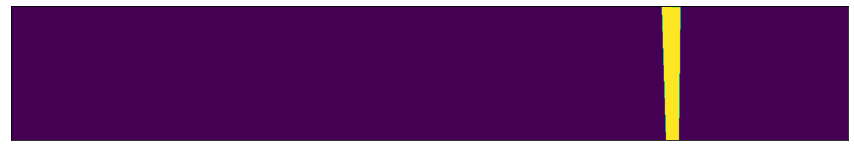

In [16]:
plt.figure(figsize=(15,5))
plt.xticks([])
plt.yticks([])
plt.imshow(flatten_mask);

In [17]:
rle = mask_tfm.decode(mask)
test_eq(rle, rles)
flatten_rle = flatten_mask_tfm.decode(flatten_mask)
test_eq(flatten_rle, rles)

Finally, a `Datasets` object can be built from the two `Pipeline`s created with the previous transforms.

In [18]:
x_tfms = Pipeline([x_tfm, PILImage.create])
y_tfms = Pipeline([y_tfm, flatten_mask_tfm, PILMask.create])
dsets = Datasets(train_pivot, [x_tfms, y_tfms])
elem = dsets.train[1]
image, mask = elem
type(elem), image, mask

(tuple, PILImage mode=RGB size=1600x256, PILMask mode=F size=1600x256)

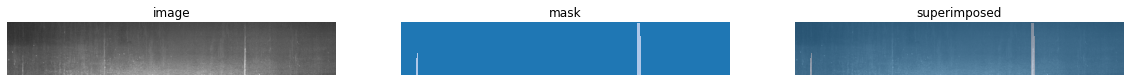

In [19]:
_,axs = plt.subplots(1,3, figsize=(20, 5))
image.show(ctx=axs[0], title='image')

mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')

image.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

### 4-channel Mask

In [20]:
# export
class ChannelMask(Transform):
    """Transform (x,y) tensor masks from [w, h] to [channels, w, h]"""
    order=9

    def create_mask(self, mask):
        new_mask = torch.zeros(4, mask.shape[0], mask.shape[1])
        for i in range(4):
            new_mask[i] = torch.where(mask==(i+1), 1, 0)
        return new_mask

    def decode_mask(self, mask, classes):
        # tensorboard log images bug in TensorBoardCallback after_epoch
        if mask.device != classes.device:
            mask = mask.to(classes.device)
        return (mask * classes).sum(0)

    def encodes(self, o:TensorMask):
        if o.dim() == 2: return self.create_mask(o)
        elif o.dim() == 3:
            new_batch = []
            for mask in o: new_batch.append(self.create_mask(mask))
            return torch.stack(new_batch, axis=0)
        else: return o

    def decodes(self, o:TensorMask):
        classes = torch.tensor(range(1,5)).unsqueeze(-1).unsqueeze(-1)
        if o.dim() == 3: return self.decode_mask(o, classes)
        elif o.dim() == 4:
            new_masks = []
            for mask in o:
                new_masks.append(self.decode_mask(mask, classes))
            return torch.stack(new_masks, axis=0)
        else: return o

The `ChannelMask` transform changes the shape of the mask from a flatten `(256, 1600)` to `(4, 256, 1600)`.

In [21]:
tens = ToTensor()
timg, tmask = tens(elem)
timg.shape, tmask.shape

(torch.Size([3, 256, 1600]), torch.Size([256, 1600]))

In [22]:
tfm = ChannelMask()
ch_mask = tfm(tmask)
ch_mask.shape

torch.Size([4, 256, 1600])

In [23]:
decoded_mask = tfm.decodes(ch_mask)
decoded_mask.shape

torch.Size([256, 1600])

In [24]:
test_close(decoded_mask, tmask)

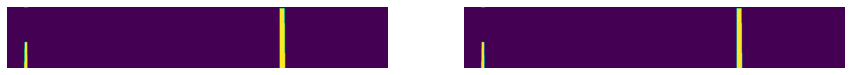

In [25]:
show_images((decoded_mask,tmask), figsize=(15,5));

### Albumentation transforms

In [26]:
img, mask = elem
img, mask = np.array(img), np.array(mask)
img.shape, mask.shape

((256, 1600, 3), (256, 1600))

Some augmentations from the `albumentation` library:

In [27]:
import cv2
def show_aug(aug, img, mask):
    aug_elem = aug(image=img, mask=mask)
    aug_crop_img = aug_elem["image"]
    aug_crop_mask = aug_elem["mask"]
    print(aug_crop_img.shape, aug_crop_mask.shape)
    print(f"Unique elems in mask: {np.unique(aug_crop_mask)}")
    show_images((aug_crop_img, aug_crop_mask), figsize=(10,20))
    return aug_crop_img, aug_crop_mask

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


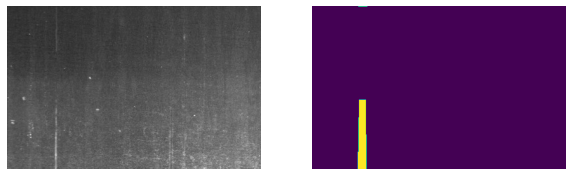

In [28]:
aug = alb.CropNonEmptyMaskIfExists(256, 400, p=1., ignore_values=[0])
aug_crop_img, aug_crop_mask = show_aug(aug, img, mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


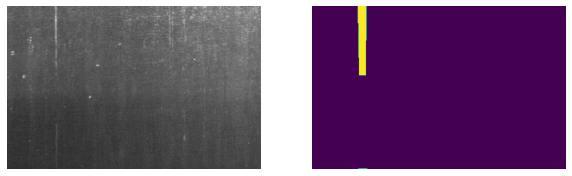

In [29]:
aug = alb.VerticalFlip(p=1.)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


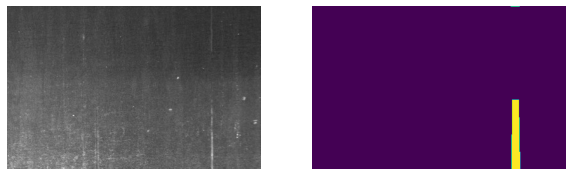

In [30]:
aug = alb.HorizontalFlip(p=1.)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


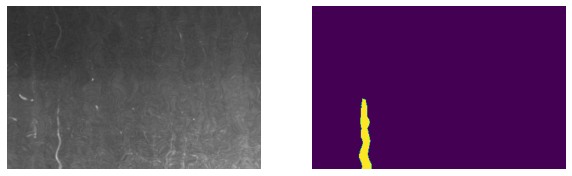

In [31]:
aug = alb.ElasticTransform(p=1., alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


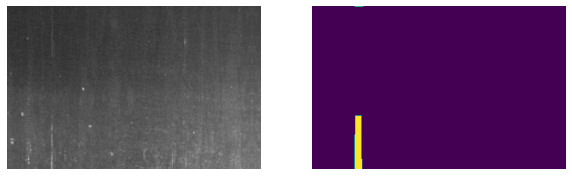

In [32]:
aug = alb.GridDistortion(p=1.)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


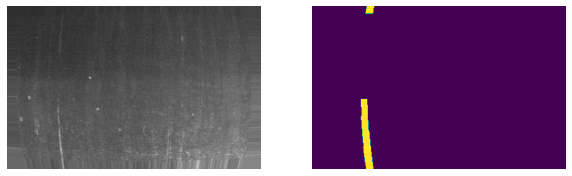

In [33]:
aug = alb.OpticalDistortion(distort_limit=0.5, shift_limit=0.05, p=1., border_mode=cv2.BORDER_REPLICATE)
aug_img, aug_mask = show_aug(aug, aug_crop_img, aug_crop_mask)

All is wrapped up in `get_train_aug` and `get_valid_aug` for training and validation augmentations.
Then `AlbumentationTransform` is a mixed Transform for the DataBlock.

In [34]:
# export
HEIGHT, WIDTH = (224, 1568)

def get_train_aug(height, width): 
    tfm_list = [
      alb.RandomCrop(height, width, p=1.0),
      #alb.Resize(128, 800),
      alb.OneOf(
          [
           alb.VerticalFlip(p=0.5),
           alb.HorizontalFlip(p=0.5),
          ], p=0.6),
      alb.OneOf(
          [
           alb.RandomBrightnessContrast(
               brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
           alb.RandomGridShuffle(grid=(1, 2), p=0.2),
          ], p=0.6),
    ]
    return alb.Compose(tfm_list)

def get_valid_aug(height, width): 
    tfms = [alb.RandomCrop(height, width)]
    return alb.Compose(tfms)
    
class AlbumentationsTransform(ItemTransform, RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): 
        self.train_aug, self.valid_aug = train_aug, valid_aug

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, o):
        img, mask = o
        if self.idx == 0:
            aug = self.train_aug(image=np.array(img),mask=np.array(mask))
            aug_img = aug['image']
            aug_mask = aug['mask']
        else:
            aug = self.valid_aug(image=np.array(img),mask=np.array(mask))
            aug_img = aug['image']
            aug_mask = aug['mask']
        return PILImage.create(aug_img), PILMask.create(aug_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


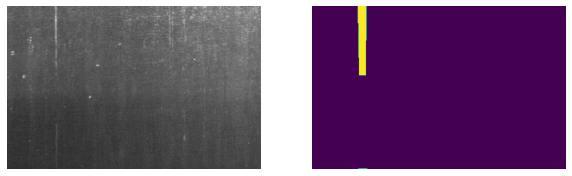

In [35]:
train_aug = get_train_aug(256, 400)
aug_img, aug_mask = show_aug(train_aug, aug_crop_img, aug_crop_mask)

(256, 400, 3) (256, 400)
Unique elems in mask: [0. 3.]


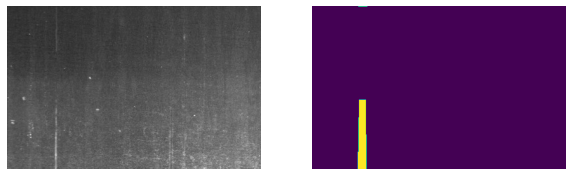

In [36]:
valid_aug = get_valid_aug(256, 400)
aug_img, aug_mask = show_aug(valid_aug, aug_crop_img, aug_crop_mask)

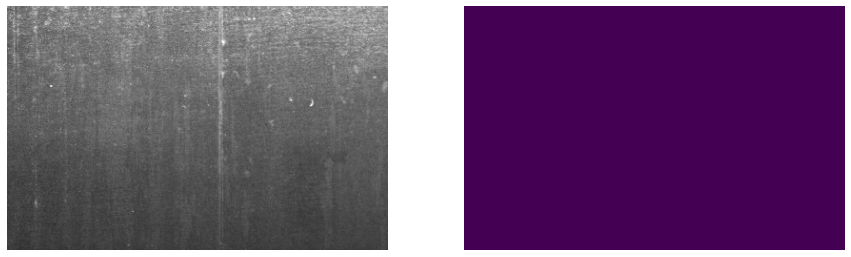

In [37]:
alb_tfm = AlbumentationsTransform(train_aug, valid_aug)
alb_aug_elem = alb_tfm(elem, split_idx=0)
show_images(alb_aug_elem, figsize=(15, 10))

### SteelMaskBlock

In [38]:
# export
def SteelMaskBlock(train_aug, valid_aug):
    # get_y tfms
    type_tfms = [
        MakeMask(), 
        PILMask.create
    ]
    # input, target tfms
    item_tfms = [
        AddMaskCodes([1,2,3,4]), 
        ToTensor(), 
        AlbumentationsTransform(train_aug, valid_aug)
    ]
    # batch tfms
    batch_tfms = [
        IntToFloatTensor(), 
        Normalize.from_stats(*imagenet_stats),
        ChannelMask()
    ]
    return TransformBlock(type_tfms=type_tfms, item_tfms=item_tfms, batch_tfms=batch_tfms)

## SteelDatablock

In [39]:
# export
def SteelDataBlock(path, splitter=None, train_aug=None, valid_aug=None, *args, **kwargs) -> DataBlock:
    """Get the DataBlock for Severstal Dataset."""
    if train_aug is None:
        train_aug = get_train_aug(HEIGHT, WIDTH)
    if valid_aug is None:
        valid_aug = get_valid_aug(HEIGHT, WIDTH)
    if splitter is None:
        splitter = TrainTestSplitter(0.2)

    steel_block = SteelMaskBlock(train_aug, valid_aug)
    block = DataBlock(
        blocks = (ImageBlock, steel_block),
        get_x = ReadImagePathFromIndex(pref=(path/"train_images")),
        get_y = ReadRLEs(),
        splitter = splitter,
        *args, **kwargs
    )
    return block

In [40]:
splitter = TrainTestSplitter(0.15)
block = SteelDataBlock(path, splitter)
dls = block.dataloaders(
    source=train_pivot, 
    bs=16, 
    num_workers=0
)
xb, yb = dls.one_batch()
xb.shape, yb.shape

C:\Users\beanTech\miniconda3\envs\steel_segmentation\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


(torch.Size([16, 3, 224, 1568]), torch.Size([16, 4, 224, 1568]))

## K-Folds strategy

The scikit-learn [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) class for this dataset.

In [52]:
nsplits = 2
# df = train_pivot[[1,2,3,4]].stack().to_frame().reset_index()
df = train_pivot.reset_index()
X = df["ImageId"].to_numpy()
y = df["ClassIds"].to_numpy()
X.shape, y.shape

((6578,), (6578,))

In [53]:
skf = StratifiedKFold(n_splits=nsplits, shuffle=True)
dsets = {i: _ for i in range(nsplits)}
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(
        f"{i}-fold:",
        f"Train: #{len(train_index)}, e.g. {train_index[:5]}", 
        f"Valid: #{len(valid_index)}, e.g. {valid_index[:5]}", 
        sep='\n', end='\n\n')

0-fold:
Train: #3289, e.g. [ 1  6 12 13 15]
Valid: #3289, e.g. [0 2 3 4 5]

1-fold:
Train: #3289, e.g. [0 2 3 4 5]
Valid: #3289, e.g. [ 1  6 12 13 15]



In [54]:
# export
def get_kfold_splits(df_pivot, nsplits=2):
    df = df_pivot.reset_index()
    X = df["ImageId"].to_numpy()
    y = df["ClassIds"].to_numpy()
    skf = StratifiedKFold(n_splits=nsplits, shuffle=True)
    splits = []
    for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(
            f"{i}-fold:",
            f"Train: #{len(train_index)}, e.g. {train_index[:5]}", 
            f"Valid: #{len(valid_index)}, e.g. {valid_index[:5]}", 
            sep='\n', end='\n\n')
        splits.append([L(list(train_index)), L(list(valid_index))])

    return splits

In [55]:
splits = get_kfold_splits(train_pivot, nsplits=2)

0-fold:
Train: #3289, e.g. [ 0  2  5  6 12]
Valid: #3289, e.g. [1 3 4 7 8]

1-fold:
Train: #3289, e.g. [1 3 4 7 8]
Valid: #3289, e.g. [ 0  2  5  6 12]



In [56]:
# export
def KFoldSplitter(splits, idx):

    def _inner(o):
        return splits[idx]

    return _inner

In [57]:
splits

[[(#3289) [0,2,5,6,12,17,18,19,23,26...],
  (#3289) [1,3,4,7,8,9,10,11,13,14...]],
 [(#3289) [1,3,4,7,8,9,10,11,13,14...],
  (#3289) [0,2,5,6,12,17,18,19,23,26...]]]

## SteelDataLoaders

In [58]:
# export
def SteelDataLoaders(block, source, bs, *args, **kwargs) -> DataLoaders:
    """Get the DataLoaders for Severstal Dataset."""
    dls = block.dataloaders(
        source=source, 
        bs=bs, 
        num_workers=0,
        *args, **kwargs
    )
    return dls

In [59]:
dls = SteelDataLoaders(block, train_pivot, bs=16, size=(256, 400))
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([16, 3, 224, 1568]), torch.Size([16, 4, 224, 1568]))

In [62]:
for idx, split in enumerate(splits):
    block = SteelDataBlock(path, splitter=KFoldSplitter(splits, idx))
    dls = SteelDataLoaders(block, train_pivot, bs=16, size=(256, 400))
    print(f"{i} - Train items:\n{dls.train.items.ClassIds.value_counts()}")
    print(f"{i} - Valid items:\n{dls.valid.items.ClassIds.value_counts()}")

1 - Train items:
3        2346
1         381
4         254
3 4       140
2          97
1 3        45
1 2        18
2 3         7
1 2 3       1
Name: ClassIds, dtype: int64
1 - Valid items:
3        2345
1         382
4         254
3 4       141
2          97
1 3        45
1 2        17
2 3         7
1 2 3       1
Name: ClassIds, dtype: int64
1 - Train items:
3        2345
1         382
4         254
3 4       141
2          97
1 3        45
1 2        17
2 3         7
1 2 3       1
Name: ClassIds, dtype: int64
1 - Valid items:
3        2346
1         381
4         254
3 4       140
2          97
1 3        45
1 2        18
2 3         7
1 2 3       1
Name: ClassIds, dtype: int64
